### Discounting Amazon Cash Flows with ML

In this notebook I will try to predict Amazon's cash flow using machine learning. Edgar only provides data since 2009 meaning a single company will have at most 56 quarterly reports. Since this is not enough data to train a model, I will also train using data from 26 major retail companies. Amazon has operated at <10% net margin over the last 3 years so I've selected retail companies that also were <10% net margin in the last reported period with the exception of Ebay.

Most of the companies in the list are "big box" retailers that rely on high volume at low net margins with the best examples being Walmart(WMT) and Coscto(COST). The data for these companies should be a good approximation for Amazon since most of Amazon's revenue is from online retail at the lowest possible prices.

In [91]:
RETAIL_TICKERS = ['amzn', 'wmt', 'cost', 'cvs', 'tgt', 'kr', 'dltr', 'dg', 'cpng', 'bby', 'aci', 'bj',
                  'musa', 'gps', 'w', 'ebay', 'aeo', 'm', 'anf', 'kss', 'go', 'psmt', 'cwh', 'woof']

In [92]:
import edgar
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

pd.set_option('display.float_format', lambda x: '%.2f' % x)

In [93]:
retail_df = pd.DataFrame()
for tkr in RETAIL_TICKERS:
    df = edgar.get_company_facts(tkr).dropna(subset=['Revenue', 'COGS', 'Income'], axis=1).fillna(0)

    for y in list(filter(lambda x: 'Q' not in x, df.columns)):
        for q in range(1, 5):
            qtr_str = f"{y}Q{q}"
            if qtr_str in df.columns and q < 4:
                df[y] -= df[qtr_str]
            elif q == 4:
                df[qtr_str] = df[y]
                df.drop(y, axis=1, inplace=True)
    scale = {k: 1000000 for k in df.index}
    scale['EPS'] = 1
    df = df.div(scale, axis=0)    
    df.loc['Gross Profit'] = df.loc['Revenue']-df.loc['COGS']
    df.loc['Ticker'] = tkr
    if df.shape[1] >= 17:
        retail_df = pd.concat([retail_df, df.sort_index(axis=1).iloc[:,-17:]], axis=1)
retail_df = retail_df.drop(['Shares', 'EPS', 'Operating Expenses', 'SG&A', 'Other Income Loss']).transpose()

In [94]:
val_tkr = ['wmt', 'dg', 'm', 'psmt']
test_tkr = ['amzn', 'w']

train_df = retail_df.loc[~retail_df['Ticker'].isin(val_tkr+test_tkr)].drop('Ticker', axis=1)
val_df = retail_df.loc[retail_df['Ticker'].isin(val_tkr)].drop('Ticker', axis=1)
test_df = retail_df.loc[retail_df['Ticker'].isin(test_tkr)].drop('Ticker', axis=1)

train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

In [95]:
INPUT_WIDTH = 16
LABEL_WIDTH = 1

In [96]:
def split_window(features):
  input_slice = slice(0, INPUT_WIDTH)
  labels_slice = slice(0, LABEL_WIDTH)
  inputs = features[:, input_slice, :]
  labels = features[:, labels_slice, :]
  if ['Income'] is not None:
    labels = tf.stack(
        [labels[:, :, {name: i for i, name in enumerate(retail_df.columns)}[name]] for name in ['Income']],
        axis=-1)

  # Slicing doesn't preserve static shape information, so set the shapes
  # manually. This way the `tf.data.Datasets` are easier to inspect.
  inputs.set_shape([None, INPUT_WIDTH, None])
  labels.set_shape([None, LABEL_WIDTH, None])

  return inputs, labels

In [97]:
def make_dataset(data):
   data = np.array(data, dtype=np.float32)
   ds = tf.keras.utils.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=INPUT_WIDTH+1,
      sequence_stride=1,
      shuffle=True,
      batch_size=8,)
   return ds.map(split_window)

Epoch 1/100
256/256 [==============================] - 1s 2ms/step - loss: 0.8151 - mean_absolute_error: 0.3871 - val_loss: 2.2013 - val_mean_absolute_error: 0.8480
Epoch 2/100
256/256 [==============================] - 0s 1ms/step - loss: 0.5417 - mean_absolute_error: 0.2927 - val_loss: 1.9519 - val_mean_absolute_error: 0.7532
Epoch 3/100
256/256 [==============================] - 0s 1ms/step - loss: 0.4129 - mean_absolute_error: 0.2487 - val_loss: 1.9415 - val_mean_absolute_error: 0.7697
Epoch 4/100
256/256 [==============================] - 0s 1ms/step - loss: 0.3399 - mean_absolute_error: 0.2665 - val_loss: 1.3649 - val_mean_absolute_error: 0.7218
Epoch 5/100
256/256 [==============================] - 0s 1ms/step - loss: 0.2311 - mean_absolute_error: 0.2331 - val_loss: 1.3924 - val_mean_absolute_error: 0.7033
Epoch 6/100
256/256 [==============================] - 0s 1ms/step - loss: 0.1676 - mean_absolute_error: 0.2135 - val_loss: 1.4430 - val_mean_absolute_error: 0.7603
Epoch 7/10

<Axes: >

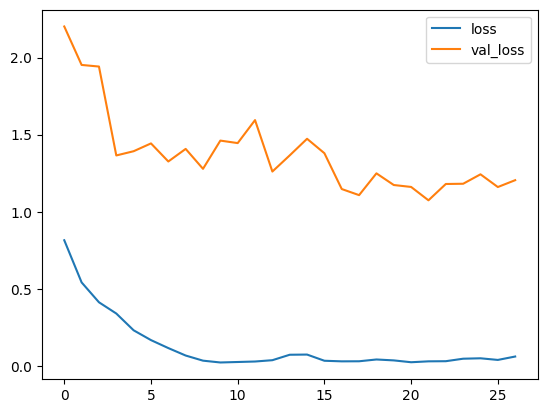

In [98]:
model = tf.keras.Sequential([
    # Shape: (time, features) => (time*features)
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1),
    # Add back the time dimension.
    # Shape: (outputs) => (1, outputs)
    tf.keras.layers.Reshape([1, -1]),
])
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, mode='min')

model.compile(loss=tf.keras.losses.MeanSquaredError(),
              optimizer=tf.keras.optimizers.Adam(),
              metrics=[tf.keras.metrics.MeanAbsoluteError()])

history = model.fit(make_dataset(train_df), epochs=100, 
                    validation_data=make_dataset(val_df), callbacks=[early_stopping])
pd.DataFrame({'loss': history.history['loss'], 'val_loss': history.history['val_loss']}).plot()

In [99]:
print(split_window(test_df).shape)
model.predict(np.array(test_df, dtype=np.float32))

InvalidIndexError: (slice(None, None, None), slice(0, 16, None), slice(None, None, None))